# Explicit solution


The solution of the forced heat equation is given by 

\begin{align}
u(t) = e^{-t\Delta}u_0 + \int_{0}^t e^{-(t-s)\Delta}\xi(s)ds
\end{align}

where 
$$
e^{-(t-s)\Delta}f = \frac{1}{\sqrt{4\pi (t-s)}} \int_{\Omega} e^{-\frac{|x-y|^2}{4(t-s)}}f(y)dy.
$$

Morally this leads to 
\begin{align}
[u(t), \psi] &= [e^{-t\Delta}u_0, \psi] + \int_{0}^t [e^{-(t-s)\Delta}\xi(s), \psi]ds \\
&= \int \int K(x-y, t)u_0(y)\psi(x)dydx + \int_{0}^t \int \int  K(x-y, t-s)\xi(y, s)\psi(x)dy dx ds \\
&= \int \int K(x-y, t)u_0(y)\psi(x)dydx + \int_{0}^t \int \Bigg(\int K(x-y, t-s)\psi(x)dx\Bigg)\xi(y, s)dy ds \\
&= [u_0,  e^{-t\Delta}\psi] + \int_{0}^t [\xi(s), e^{-(t-s)\Delta}\psi]ds
\end{align}

We then discretize

$$
\int K(x-y, t-s)\psi(x)dx \approx \sum_{i=1}^N w_i K(y -x_i, t-s)\psi(x_i)
$$

In order to sample $[\xi(s), e^{-(t-s)\Delta}\psi]$, we need to compute 
\begin{align}
\langle  e^{-(t-s)\Delta}\psi_i,  e^{-(t-s)\Delta}\psi_j \rangle_{L^2}
\end{align}

and hence compute 
$$
\int \Big( \int K(y-x, t-s)\psi_m(x) dx\Big) \Big(\int K(y-z, t-s)\psi_n(z)dz \Big) dy  
$$
which can be discretized as 

$$
\sum_i \sum_j \sum_k w_i   K(y_i-x_j, t-s) K(y_i-z_k, t-s) w_j \psi_m(x_j)w_k\psi_n(z_k) = (\bold{K}\psi_m)^\intercal \bold{W} \bold{K}\psi_n
$$

Hence we solve

$$
[du_t, \psi] = [ e^{-t\Delta}dW_t, \psi]
$$

Which we discretize 
$$
u_{n+1} = u_n + \sqrt{h}[\xi, e^{-h\Delta}\psi]
$$


In [ ]:
def heat_kernel(x, y, t,s):
    return jnp.exp(-(x-y)**2/(4*(t-s)))/jnp.sqrt(4*jnp.pi*(t-s))

vmap_heat_kernel = jit(vmap(vmap(heat_kernel, (None, 0, None, None)), (0, None, None, None)))

def compute_heat_ip(psi_1, psi_2, roots_1, roots_2, roots_domain, w_domain, t, s):
    K_1 = vmap_heat_kernel(roots_domain, roots_1, t ,s)
    K_2 = vmap_heat_kernel(roots_domain, roots_2, t ,s)

    return psi_1@K_1.T@jnp.diag(w_domain)@K_2@psi_2

vmap_heat_ip = jit(vmap(vmap(compute_heat_ip, (0, None, 0, None, None, None, None, None)), (None, 0, None, 0, None, None, None, None)))

In [ ]:
roots_domain, w_domain = root_interval(roots_legendre(20)[0], roots_legendre(20)[1], boundary)

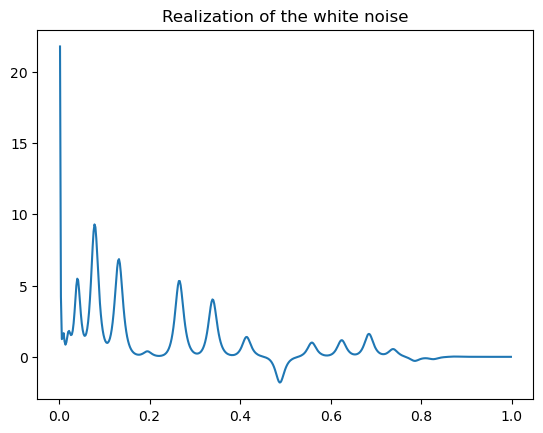

In [ ]:
heat_matrix = vmap_heat_ip(psi_matrix, psi_matrix, root_psi, root_psi, roots_domain, w_domain, h, 0.0)
L_heat = scipy.linalg.cholesky(heat_matrix + 1e-10*jnp.eye(N_tent))

key = random.PRNGKey(312)
xi =  L_heat@random.normal(key, (N_tent,))
plt.plot(centers, xi)
plt.title('Realization of the white noise')
plt.show()

In [ ]:
def integrate_heat_solution(h, y_init,sigma, key):
    # Build the heat kernel
    heat_matrix = vmap_heat_ip(psi_matrix, psi_matrix, root_psi, root_psi, roots_domain, w_domain, h, 0.0)
    L_heat = scipy.linalg.cholesky(heat_matrix + 1e-10*jnp.eye(N_tent))


    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    y = y_init

    for i in range(N):
        key, subkey = random.split(key)        
        # Sample from the space time white noise
        xi = L_heat@random.normal(subkey, (N_tent,))

        # Create the right hand side
        y = y + sigma*jnp.sqrt(h)*xi
        #print(xi[0])


    return y

In [ ]:
h= 0.001
T= 1.0
sigma = 10.0
y_exact = integrate_heat_solution(h, y_init, 1.0, key)

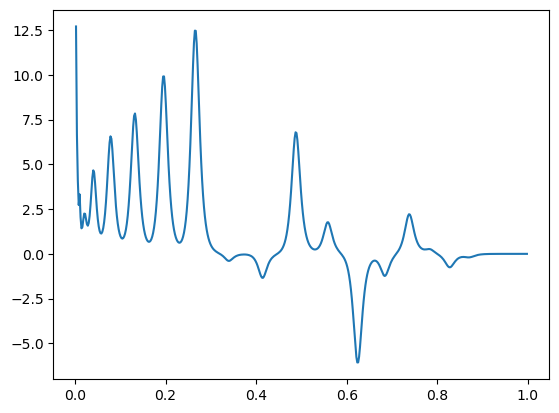

In [ ]:
plt.plot(centers, y_exact)